## Stage 1: Install dependencies and setting up GPU environment

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  13080      0 --:--:-- --:--:-- --:--:-- 13080
OK


In [26]:
!apt-get update && apt-get install tensorflow-model-server

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,813 kB]
Ign:13 https://developer.download.nvidia.com/compute/machine-

In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 23 kB/s 


In [1]:
!pip install requests

## Stage 2: Import project dependencies

In [2]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.7.0'

## Stage 3: Dataset preprocessing

### Loading the dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
X_train.shape

(50000, 32, 32, 3)

## Stage 4: Defining the model

NOTE: We are using the model from the Section for Convolutional neural networks

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compiling the model

In [8]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Training the model

In [9]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 20s 22ms/step - loss: 1.4742 - sparse_categorical_accuracy: 0.4694
Epoch 2/10
391/391 [==============================] - 9s 22ms/step - loss: 1.0395 - sparse_categorical_accuracy: 0.6331
Epoch 3/10
391/391 [==============================] - 8s 22ms/step - loss: 0.8596 - sparse_categorical_accuracy: 0.6980
Epoch 4/10
391/391 [==============================] - 9s 22ms/step - loss: 0.7353 - sparse_categorical_accuracy: 0.7439
Epoch 5/10
391/391 [==============================] - 8s 22ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.7798
Epoch 6/10
391/391 [==============================] - 8s 22ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.8073
Epoch 7/10
391/391 [==============================] - 8s 22ms/step - loss: 0.4763 - sparse_categorical_accuracy: 0.8337
Epoch 8/10
391/391 [==============================] - 8s 22ms/step - loss: 0.3969 - sparse_categorical_accuracy: 0.8611
Epoch 9/10
391/391 [===================

### Model evaluation

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.9970 - sparse_categorical_accuracy: 0.7355


In [11]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.7228000164031982


## Stage 5: Saving the model for production

### Creating the directory for the model

In [15]:
MODEL_DIR = "model"
version = 1

In [16]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [13]:
# Just the check to remove this folder with export path if it exist via bash command
if os.path.isdir(export_path):
    !rm -r {export_path}

### Saving the model for the TensorFlow Serving

In [14]:
tf.saved_model.save(model, export_dir=export_path)

INFO:tensorflow:Assets written to: model/1/assets


## Stage 6: Setting up the production environment

### Exporting the MODEL_DIR to environment variables

In [17]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Running the TensorFlow Serving REST API

In [27]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [28]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Stage 7: Creating the first POST request

In [29]:
random_image = np.random.randint(0, len(X_test))
random_image

270

### Creating the JSON data object

In [30]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [31]:
data

'{"signature_name": "serving_default", "instances": [[[[0.3137254901960784, 0.32941176470588235, 0.2], [0.30980392156862746, 0.3215686274509804, 0.19607843137254902], [0.30980392156862746, 0.3254901960784314, 0.19607843137254902], [0.3215686274509804, 0.33725490196078434, 0.20392156862745098], [0.34509803921568627, 0.3607843137254902, 0.2235294117647059], [0.36470588235294116, 0.3764705882352941, 0.23529411764705882], [0.3607843137254902, 0.3686274509803922, 0.23529411764705882], [0.3686274509803922, 0.37254901960784315, 0.25882352941176473], [0.4, 0.4, 0.2901960784313726], [0.4196078431372549, 0.4196078431372549, 0.30980392156862746], [0.4117647058823529, 0.40784313725490196, 0.30196078431372547], [0.4, 0.4, 0.29411764705882354], [0.41568627450980394, 0.4235294117647059, 0.30980392156862746], [0.42745098039215684, 0.44313725490196076, 0.3176470588235294], [0.4196078431372549, 0.42745098039215684, 0.3058823529411765], [0.3764705882352941, 0.3686274509803922, 0.2627450980392157], [0.329

### Sending the first POST request to the model

In [32]:
headers = {"content-type":"application/json"}

In [33]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)

In [34]:
json_response

<Response [200]>

In [35]:
predictions = json.loads(json_response.text)['predictions']

In [36]:
predictions

[[1.4235944e-05,
  4.11423429e-09,
  0.832559586,
  0.133578569,
  0.00238525379,
  0.0164920148,
  0.000882117776,
  0.0140876267,
  2.03072958e-07,
  2.89136779e-07]]

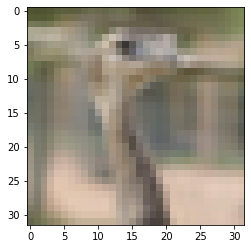

In [37]:
plt.imshow(X_test[random_image])

In [38]:
class_names[np.argmax(predictions[0])]

'bird'

## Stage 8: Sending the POST request to a specific model

In [39]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [40]:
specific_json_response

<Response [200]>